---
### Step 1: Import Data and put into train, val and test datasets

In [70]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

In [71]:
# Data path
CSV_PATH = '/Users/Michael/Desktop/MentalHealthDataset.csv'

# Load CSV
df = pd.read_csv(CSV_PATH)

# Convert the DataFrame to a NumPy array
mh_array = df.to_numpy()

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Grab text and labels only
X = mh_array[:, 1] #text
y = mh_array[:, 2] #labels

# Encode labels as integers for Tensorflow
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train, val and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [73]:
# Label mapping for future reference
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


In [74]:
# Make sure text data is string for conversion
X_train = X_train.astype(str)
X_test = X_test.astype(str)
X_val = X_val.astype(str)

# Convert the data into TensorFlow to match in-class exercise way of text encoding
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

---
### Step 2: Perform EDA on the training data

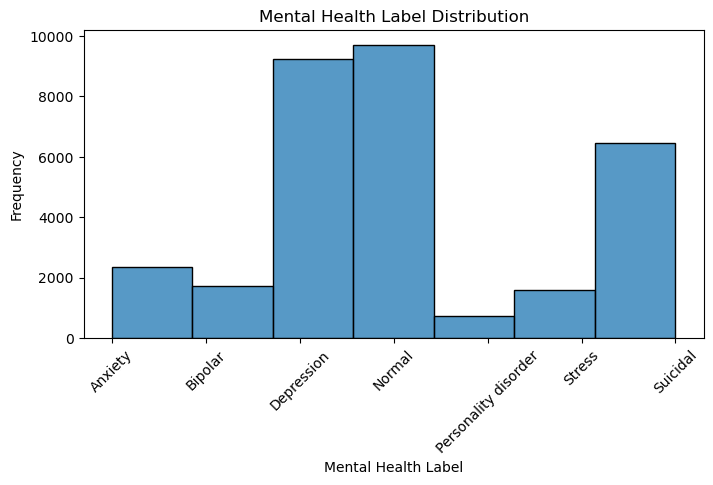

In [44]:
# Hist of label dist
plt.figure(figsize=(8, 4))
sns.histplot(y_train, kde=False, bins=len(label_mapping))
plt.title('Mental Health Label Distribution')
plt.xlabel('Mental Health Label')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(len(label_mapping)), labels=label_encoder.classes_, rotation=45)
plt.show()


/var/folders/q4/7kmhvqb10xd9y9bv1_ytb5d40000gn/T/ipykernel_44430/277831011.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='label', y='char_count', data=df_char_count, estimator=np.median, ci=None)


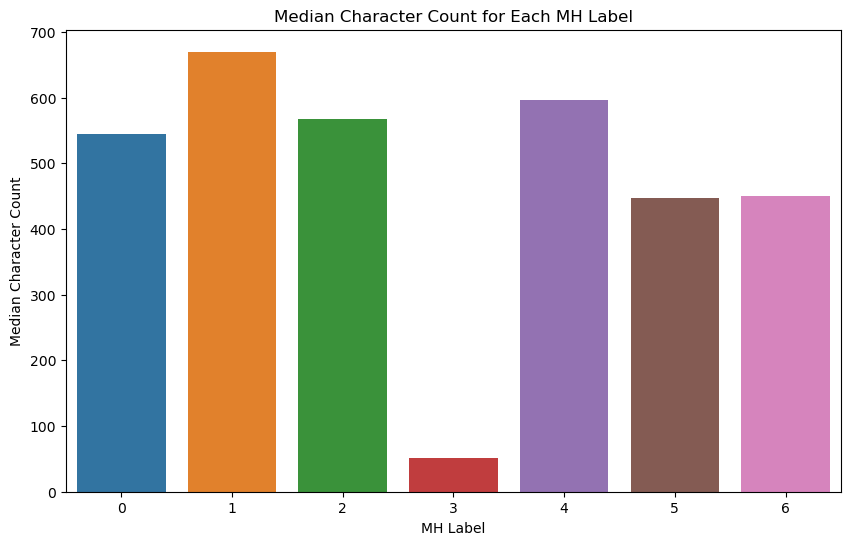

In [60]:
# Count characters in each
char_count = np.array([len(text) for text in X_train])

# Create df for plotting
df_char_count = pd.DataFrame({
    'label': y_train,
    'char_count': char_count
})

# Plot hist
plt.figure(figsize=(10,6))
sns.barplot(x='label', y='char_count', data=df_char_count, estimator=np.median, ci=None)
plt.title('Median Character Count for Each MH Label')
plt.xlabel('MH Label')
plt.ylabel('Median Character Count')
plt.show()


In [77]:
# Function to check if the label word exists in input
def label_word_in_text(label_word, text):
    return label_word.lower() in text.lower()

# Dictionary to count where label word exists in the text
label_word_exists_count = {label: 0 for label in label_mapping.values()}

# Dictionary to count rows per label
label_total_count = {label: 0 for label in label_mapping.values()}

# Loop and count
for text, label in zip(X_train, y_train):
    label_word = label_encoder.classes_[label]  # Get the word representing the label
    label_total_count[label] += 1  # Increment total count for each label
    if label_word_in_text(label_word, text):
        label_word_exists_count[label] += 1


for label_index in label_mapping.values():
    label_name = label_encoder.classes_[label_index]
    total_count = label_total_count[label_index]
    exists_count = label_word_exists_count[label_index]
    print(f"Label: {label_name}, Total rows: {total_count}, Rows with label word: {exists_count}, % of total rows with label word: {round((exists_count/total_count) * 100,2)}%")


Label: Anxiety, Total rows: 2362, Rows with label word: 1104, % of total rows with label word: 46.74%
Label: Bipolar, Total rows: 1727, Rows with label word: 641, % of total rows with label word: 37.12%
Label: Depression, Total rows: 9248, Rows with label word: 2743, % of total rows with label word: 29.66%
Label: Normal, Total rows: 9710, Rows with label word: 37, % of total rows with label word: 0.38%
Label: Personality disorder, Total rows: 726, Rows with label word: 24, % of total rows with label word: 3.31%
Label: Stress, Total rows: 1600, Rows with label word: 527, % of total rows with label word: 32.94%
Label: Suicidal, Total rows: 6452, Rows with label word: 744, % of total rows with label word: 11.53%


---
### Step 3: Shuffle and batch data and then standardize, tokenize, and vectorize the data.

In [75]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])
  

texts:  [b'You DO know that you have absolutely no power... yet. And when you do, this whole thing will be dead and forgotten.\xc3\xa2\xc2\x80\xc2\xa6 https://t.co/eZRhCl3IWc'
 b'@alexasberthold,The Moon,I cant do this im a fucking wreck i havent touched a thing at work i have cried here since 8am but i dont want to leave because i have to go say goodbye to someone i shouldnt be. Idk what to do with myself anymore'
 b'I do not know how I am doing this. Its like I have detached from my own body &amp; mind. I am watching myself be a robot &amp; somehow its easier to do that than to drown in your own head. I really do not know who I am. I have been functioning by disassociating.']

labels:  [6 6 2]


In [76]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

encoded_example = encoder(example)[:3].numpy()
encoded_example

for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'You DO know that you have absolutely no power... yet. And when you do, this whole thing will be dead and forgotten.\xc3\xa2\xc2\x80\xc2\xa6 https://t.co/eZRhCl3IWc'
Round-trip:  you do know that you have absolutely no [UNK] yet and when you do this whole thing will be dead and [UNK] [UNK]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

2024-11-13 13:51:33.499740: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
